# Q1. Document Classification

### Q1.1. Reuters Dataset Exploration

##### Out-of-core classification of text documents:


In [172]:
from __future__ import print_function

from glob import glob
import itertools
import os.path
import re
import tarfile
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.externals.six.moves import html_parser
from sklearn.externals.six.moves import urllib
from sklearn.datasets import get_data_home
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB


def _not_in_sphinx():
    # Hack to detect whether we are running by the sphinx builder
    return '__file__' in globals()

In [173]:
class ReutersParser(html_parser.HTMLParser):
    """Utility class to parse a SGML file and yield documents one at a time."""

    def __init__(self, encoding='latin-1'):
        html_parser.HTMLParser.__init__(self)
        self._reset()
        self.encoding = encoding

    def handle_starttag(self, tag, attrs):
        method = 'start_' + tag
        getattr(self, method, lambda x: None)(attrs)

    def handle_endtag(self, tag):
        method = 'end_' + tag
        getattr(self, method, lambda: None)()

    def _reset(self):
        self.in_title = 0
        self.in_body = 0
        self.in_topics = 0
        self.in_topic_d = 0
        self.title = ""
        self.body = ""
        self.topics = []
        self.topic_d = ""

    def parse(self, fd):
        self.docs = []
        for chunk in fd:
            self.feed(chunk.decode(self.encoding))
            for doc in self.docs:
                yield doc
            self.docs = []
        self.close()

    def handle_data(self, data):
        if self.in_body:
            self.body += data
        elif self.in_title:
            self.title += data
        elif self.in_topic_d:
            self.topic_d += data

    def start_reuters(self, attributes):
        pass

    def end_reuters(self):
        self.body = re.sub(r'\s+', r' ', self.body)
        self.docs.append({'title': self.title,
                          'body': self.body,
                          'topics': self.topics})
        self._reset()

    def start_title(self, attributes):
        self.in_title = 1

    def end_title(self):
        self.in_title = 0

    def start_body(self, attributes):
        self.in_body = 1

    def end_body(self):
        self.in_body = 0

    def start_topics(self, attributes):
        self.in_topics = 1

    def end_topics(self):
        self.in_topics = 0

    def start_d(self, attributes):
        self.in_topic_d = 1

    def end_d(self):
        self.in_topic_d = 0
        self.topics.append(self.topic_d)
        self.topic_d = ""


def stream_reuters_documents(data_path=None):
    """Iterate over documents of the Reuters dataset.

    The Reuters archive will automatically be downloaded and uncompressed if
    the `data_path` directory does not exist.

    Documents are represented as dictionaries with 'body' (str),
    'title' (str), 'topics' (list(str)) keys.

    """

    DOWNLOAD_URL = ('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                    'reuters21578-mld/reuters21578.tar.gz')
    ARCHIVE_FILENAME = 'reuters21578.tar.gz'

    if data_path is None:
        data_path = os.path.join(get_data_home(), "reuters")
    if not os.path.exists(data_path):
        """Download the dataset."""
        print("downloading dataset (once and for all) into %s" %
              data_path)
        os.mkdir(data_path)

        def progress(blocknum, bs, size):
            total_sz_mb = '%.2f MB' % (size / 1e6)
            current_sz_mb = '%.2f MB' % ((blocknum * bs) / 1e6)
            if _not_in_sphinx():
                print('\rdownloaded %s / %s' % (current_sz_mb, total_sz_mb),
                      end='')

        archive_path = os.path.join(data_path, ARCHIVE_FILENAME)
        urllib.request.urlretrieve(DOWNLOAD_URL, filename=archive_path,
                                   reporthook=progress)
        if _not_in_sphinx():
            print('\r', end='')
        print("untarring Reuters dataset...")
        tarfile.open(archive_path, 'r:gz').extractall(data_path)
        print("done.")

    parser = ReutersParser()
    for filename in glob(os.path.join(data_path, "*.sgm")):
        for doc in parser.parse(open(filename, 'rb')):
            yield doc

In [176]:
vectorizer = HashingVectorizer(decode_error='ignore', n_features=2 ** 18,
                               non_negative=True)


# Iterator over parsed Reuters SGML files.
data_stream = stream_reuters_documents()

# We learn a binary classification between the "acq" class and all the others.
# "acq" was chosen as it is more or less evenly distributed in the Reuters
# files. For other datasets, one should take care of creating a test set with
# a realistic portion of positive instances.
all_classes = np.array([0, 1])
positive_class = 'acq'

# Here are some classifiers that support the `partial_fit` method
partial_fit_classifiers = {
    'SGD': SGDClassifier(),
    'Perceptron': Perceptron(),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(),
}


def get_minibatch(doc_iter, size, pos_class=positive_class):
    """Extract a minibatch of examples, return a tuple X_text, y.

    Note: size is before excluding invalid docs with no topics assigned.

    """
    data = [(u'{title}\n\n{body}'.format(**doc), pos_class in doc['topics'])
            for doc in itertools.islice(doc_iter, size)
            if doc['topics']]
    if not len(data):
        return np.asarray([], dtype=int), np.asarray([], dtype=int)
    X_text, y = zip(*data)
    return X_text, np.asarray(y, dtype=int)


def iter_minibatches(doc_iter, minibatch_size):
    """Generator of minibatches."""
    X_text, y = get_minibatch(doc_iter, minibatch_size)
    while len(X_text):
        yield X_text, y
        X_text, y = get_minibatch(doc_iter, minibatch_size)


# test data statistics
test_stats = {'n_test': 0, 'n_test_pos': 0}

# First we hold out a number of examples to estimate accuracy
n_test_documents = 1000
tick = time.time()
X_test_text, y_test = get_minibatch(data_stream, 1000)
parsing_time = time.time() - tick
tick = time.time()
X_test = vectorizer.transform(X_test_text)
vectorizing_time = time.time() - tick
test_stats['n_test'] += len(y_test)
test_stats['n_test_pos'] += sum(y_test)
print("Test set is %d documents (%d positive)" % (len(y_test), sum(y_test)))


def progress(cls_name, stats):
    """Report progress information, return a string."""
    duration = time.time() - stats['t0']
    s = "%20s classifier : \t" % cls_name
    s += "%(n_train)6d train docs (%(n_train_pos)6d positive) " % stats
    s += "%(n_test)6d test docs (%(n_test_pos)6d positive) " % test_stats
    s += "accuracy: %(accuracy).3f " % stats
    s += "in %.2fs (%5d docs/s)" % (duration, stats['n_train'] / duration)
    return s


cls_stats = {}

for cls_name in partial_fit_classifiers:
    stats = {'n_train': 0, 'n_train_pos': 0,
             'accuracy': 0.0, 'accuracy_history': [(0, 0)], 't0': time.time(),
             'runtime_history': [(0, 0)], 'total_fit_time': 0.0}
    cls_stats[cls_name] = stats

get_minibatch(data_stream, n_test_documents)
# Discard test set

# We will feed the classifier with mini-batches of 1000 documents; this means
# we have at most 1000 docs in memory at any time.  The smaller the document
# batch, the bigger the relative overhead of the partial fit methods.
minibatch_size = 1000

# Create the data_stream that parses Reuters SGML files and iterates on
# documents as a stream.
minibatch_iterators = iter_minibatches(data_stream, minibatch_size)
total_vect_time = 0.0

# Main loop : iterate on mini-batches of examples
for i, (X_train_text, y_train) in enumerate(minibatch_iterators):

    tick = time.time()
    X_train = vectorizer.transform(X_train_text)
    total_vect_time += time.time() - tick

    for cls_name, cls in partial_fit_classifiers.items():
        tick = time.time()
        # update estimator with examples in the current mini-batch
        cls.partial_fit(X_train, y_train, classes=all_classes)

        # accumulate test accuracy stats
        cls_stats[cls_name]['total_fit_time'] += time.time() - tick
        cls_stats[cls_name]['n_train'] += X_train.shape[0]
        cls_stats[cls_name]['n_train_pos'] += sum(y_train)
        tick = time.time()
        cls_stats[cls_name]['accuracy'] = cls.score(X_test, y_test)
        cls_stats[cls_name]['prediction_time'] = time.time() - tick
        acc_history = (cls_stats[cls_name]['accuracy'],
                       cls_stats[cls_name]['n_train'])
        cls_stats[cls_name]['accuracy_history'].append(acc_history)
        run_history = (cls_stats[cls_name]['accuracy'],
                       total_vect_time + cls_stats[cls_name]['total_fit_time'])
        cls_stats[cls_name]['runtime_history'].append(run_history)

        if i % 3 == 0:
            print(progress(cls_name, cls_stats[cls_name]))
    if i % 3 == 0:
        print('\n')

Test set is 986 documents (159 positive)
                 SGD classifier : 	   931 train docs (   123 positive)    986 test docs (   159 positive) accuracy: 0.871 in 7.48s (  124 docs/s)
          Perceptron classifier : 	   931 train docs (   123 positive)    986 test docs (   159 positive) accuracy: 0.901 in 7.50s (  124 docs/s)
      NB Multinomial classifier : 	   931 train docs (   123 positive)    986 test docs (   159 positive) accuracy: 0.841 in 7.67s (  121 docs/s)
  Passive-Aggressive classifier : 	   931 train docs (   123 positive)    986 test docs (   159 positive) accuracy: 0.836 in 7.69s (  121 docs/s)


                 SGD classifier : 	  3847 train docs (   450 positive)    986 test docs (   159 positive) accuracy: 0.923 in 19.88s (  193 docs/s)
          Perceptron classifier : 	  3847 train docs (   450 positive)    986 test docs (   159 positive) accuracy: 0.928 in 19.90s (  193 docs/s)
      NB Multinomial classifier : 	  3847 train docs (   450 positive)    986 t

### Plot results:

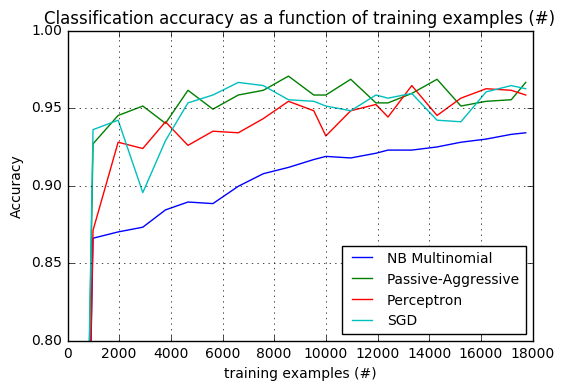

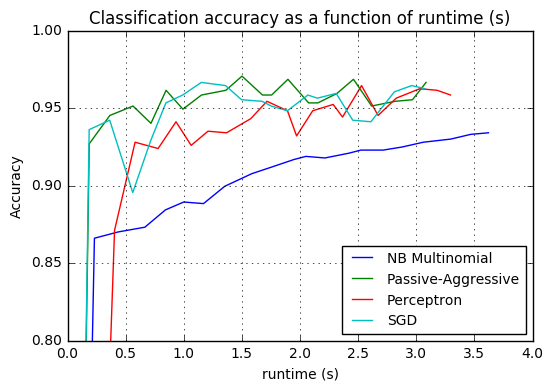

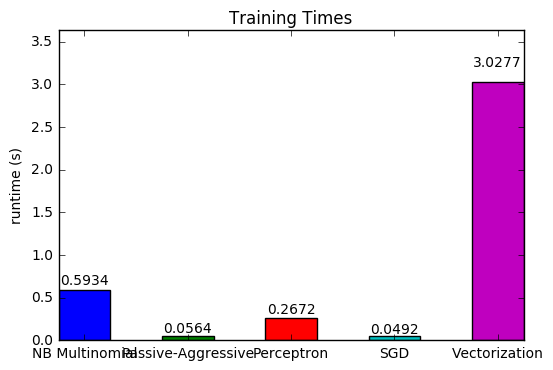

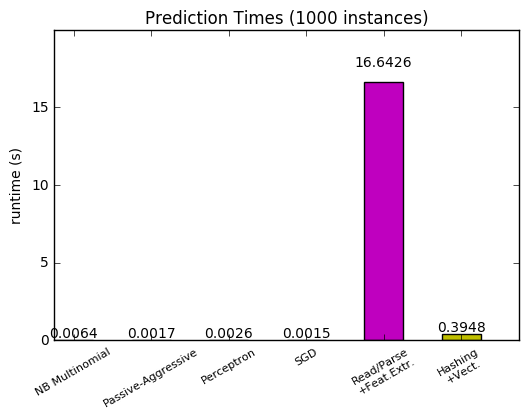

In [4]:
def plot_accuracy(x, y, x_legend):
    """Plot accuracy as a function of x."""
    x = np.array(x)
    y = np.array(y)
    plt.title('Classification accuracy as a function of %s' % x_legend)
    plt.xlabel('%s' % x_legend)
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.plot(x, y)

rcParams['legend.fontsize'] = 10
cls_names = list(sorted(cls_stats.keys()))

# Plot accuracy evolution
plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with #examples
    accuracy, n_examples = zip(*stats['accuracy_history'])
    plot_accuracy(n_examples, accuracy, "training examples (#)")
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')

plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with runtime
    accuracy, runtime = zip(*stats['runtime_history'])
    plot_accuracy(runtime, accuracy, 'runtime (s)')
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc='best')

# Plot fitting times
plt.figure()
fig = plt.gcf()
cls_runtime = []
for cls_name, stats in sorted(cls_stats.items()):
    cls_runtime.append(stats['total_fit_time'])

cls_runtime.append(total_vect_time)
cls_names.append('Vectorization')
bar_colors = ['b', 'g', 'r', 'c', 'm', 'y']

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5,
                     color=bar_colors)

ax.set_xticks(np.linspace(0.25, len(cls_names) - 0.75, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=10)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel('runtime (s)')
ax.set_title('Training Times')


def autolabel(rectangles):
    """attach some text vi autolabel on rectangles."""
    for rect in rectangles:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2.,
                1.05 * height, '%.4f' % height,
                ha='center', va='bottom')

autolabel(rectangles)
plt.show()

# Plot prediction times
plt.figure()
cls_runtime = []
cls_names = list(sorted(cls_stats.keys()))
for cls_name, stats in sorted(cls_stats.items()):
    cls_runtime.append(stats['prediction_time'])
cls_runtime.append(parsing_time)
cls_names.append('Read/Parse\n+Feat.Extr.')
cls_runtime.append(vectorizing_time)
cls_names.append('Hashing\n+Vect.')

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5,
                     color=bar_colors)

ax.set_xticks(np.linspace(0.25, len(cls_names) - 0.75, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=8)
plt.setp(plt.xticks()[1], rotation=30)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel('runtime (s)')
ax.set_title('Prediction Times (%d instances)' % n_test_documents)
autolabel(rectangles)
plt.show()

1.2) Explore how many documents are in the dataset, how many categories, how many documents per categories, provide mean and standard deviation, min and max. (use the pandas library to explore the dataset, use the dataframe.describe() method.) 

In [170]:
import pandas as pand
from pandas import DataFrame

In [177]:
data_stream = stream_reuters_documents()
df = pand.DataFrame(data_stream)
df

,body,title,topics
0,The Bank of England said it forecast a shortag...,U.K. MONEY MARKET SHORTAGE FORECAST AT 250 MLN...,"[money-fx, uk]"
1,The Bank of France said it invited offers of f...,BANK OF FRANCE SETS MONEY MARKET TENDER,"[money-fx, interest, france]"
2,The U.S. <Amoco Petroleum Corp> has reported a...,AMOCO REPORTS SOUTH CHINA SEA OIL FIND,"[crude, china]"
3,Technology transfer problems have delayed the ...,SOUTH KOREA DELAYS CONTRACT FOR NUCLEAR PLANTS,[south-korea]
4,Keiaisha Co Ltd of Tokyo is issuing 12 mln Swi...,KEIAISHA ISSUING 12 MLN SWISS FRANC NOTES,[switzerland]
5,,NATIONAL WESTMINSTER BANK SAYS IT CUTTING BASE...,[interest]
6,National Westminster Bank Plc said it has cut ...,NATIONAL WESTMINSTER BANK CUTS BASE RATE,"[interest, uk]"
7,Semi-annual dividend 4 cts Pay May 29 Record A...,U.S. FACILITIES <USRE> SEMI-ANNUAL DIVIDEND,"[earn, usa]"
8,Standard Pacific LP said it has acquired subst...,STANDARD PACIFIC <SPF> ACQUIRES SOUTH BAY S/L,"[acq, usa]"
9,The Treasury Department said it would temporar...,U.S. TO ALLOW TEMPORARY IMPORTS OF S.A. URANIUM,"[strategic-metal, usa, south-africa]"


In [76]:
df['body'].describe()

count     21578
unique    18763
top            
freq       2535
Name: body, dtype: object

In [38]:
df['title'].describe()

count     21578
unique    20030
top            
freq        737
Name: title, dtype: object

In [52]:
numOfDocs = df['title'].describe()['count']
print("Number of documents in the Dataset :")
print(numOfDocs)
print('\n')

Number of documents in the Dataset :
21578




In [43]:
df['topics']

0                                              [earn, usa]
1        [wheat, corn, soybean, grain, oilseed, usa, ussr]
2                                       [sugar, uk, india]
3                                                    [usa]
4                                              [earn, usa]
5                                                     [uk]
6                              [acq, strategic-metal, usa]
7                                     [coffee, ico-coffee]
8                                [wheat, grain, usa, ussr]
9                                          [interest, usa]
10       [coffee, uk, brazil, guatemala, colombia, ico-...
11                                                   [usa]
12                                   [yugoslavia, mikulic]
13                                             [earn, usa]
14                                                   [usa]
15                                         [interest, usa]
16                                             [earn, us

In [178]:
## now we want to count the catogries
ListOflistsTopics = list(df['topics'])
FlattenTopics = sum(ListOflistsTopics , [])
Topics = set(FlattenTopics)
NumOfCatg = len(Topics)

print("Number of categories in the Dataset :")
print(NumOfCatg)
print('\n')

Number of categories in the Dataset :
445




In [179]:
import nltk
#Since each document can belong to several catogries , we will create FreqDist
freqDist = nltk.FreqDist(FlattenTopics)
freqDist

FreqDist({'acq': 2448,
          'adb-africa': 10,
          'adb-asia': 20,
          'afghanistan': 3,
          'alfonsin': 2,
          'algeria': 35,
          'alum': 63,
          'amex': 60,
          'andriessen': 1,
          'angola': 2,
          'antigua': 1,
          'aqazadeh': 6,
          'aquino': 4,
          'argentina': 90,
          'aruba': 1,
          'ase': 11,
          'asean': 2,
          'asx': 5,
          'atpc': 3,
          'austdlr': 4,
          'australia': 270,
          'austria': 27,
          'babangida': 2,
          'bahamas': 1,
          'bahrain': 46,
          'balladur': 35,
          'bangemann': 6,
          'bangladesh': 34,
          'barbados': 3,
          'barley': 54,
          'belgium': 214,
          'benin': 1,
          'bermuda': 4,
          'bfr': 1,
          'bhutan': 1,
          'biffex': 4,
          'bis': 2,
          'boesky': 11,
          'bolivia': 23,
          'bond': 1,
          'bop': 116,
          'bots

Lets make sure this is the same amount of categories as before:

In [86]:
len(freqDist)


445

We're going to add a length column to our dataframe, which represents how many words are in each text document:

#### providing mean and standard deviation, min and max: (for words)

In [5]:
df['length'] = df['body'].map(lambda text: len(text))
df

,body,title,topics,length
0,Qtly div 30 cts vs 30 cts prior Pay April 27 R...,REPUBLIC SAVINGS AND LOAN <RSLA> SETS DIVIDEND,"[earn, usa]",149
1,Speculation the United States will offer subsi...,SHULTZ USSR TRIP FUELS TALK OF EEP WHEAT OFFER,"[wheat, corn, soybean, grain, oilseed, usa, ussr]",4075
2,London-based sugar operator Kaines Ltd confirm...,KAINES CONFIRMS WHITE SUGAR SALES TO INDIA,"[sugar, uk, india]",310
3,Luxtec Corp said it has reduced the exercise p...,LUXTEC <LUXT> CUTS WARRANT EXERCISE PRICE,[usa],157
4,Oper net 94.4 mln vs 74.1 mln Revs 1.3 bilion ...,<THL HOLDINGS INC> YEAR JAN 31 NET,"[earn, usa]",161
5,Insurance group Guardian Royal Exchange Plc <G...,GUARDIAN ROYAL SEES EXPANSION IN LIFE ASSURANCE,[uk],597
6,Mountain States Resources Corp said it acquire...,MOUNTAIN STATES ADDS TWO MINERALS PROPERTIES,"[acq, strategic-metal, usa]",461
7,,RESTORATION OF COFFEE EXPORT QUOTAS BEFORE\n O...,"[coffee, ico-coffee]",0
8,Speculation the United States will offer subsi...,SHULTZ USSR TRIP FUELS TALK OF EEP WHEAT OFFER,"[wheat, grain, usa, ussr]",548
9,The Federal Home Loan Mortgage Corp adjusted t...,FREDDIE MAC ADJUSTS SHORT-TERM DISCOUNT RATES,"[interest, usa]",171


In [129]:
df['length'].describe()


count    21578.000000
mean       718.527621
std        819.414178
min          0.000000
25%        235.000000
50%        491.000000
75%        904.000000
max       9875.000000
Name: length, dtype: float64

In [120]:
#we want to create dataframe of topics (catgories) , first we want to create dictionary of topics
values =[(x, y) for (x, y) in freqDist.items()] 
values
DocumnetsPerCatgory_dataframe = pand.DataFrame(values ,columns=['Topic','Number Of docs'])
DocumnetsPerCatgory_dataframe

,Topic,Number Of docs
0,libya,16
1,maxwell,1
2,nycsce,6
3,atpc,3
4,austdlr,4
5,fiji,3
6,mitterrand,1
7,rapeseed,35
8,rape-meal,1
9,yemen-arab-republic,8


#### providing mean and standard deviation, min and max: (for catogries)

In [121]:
DocumnetsPerCatgory_dataframe.describe()

,Number Of docs
count,445.000000
mean,89.871910
std,644.656909
min,1.000000
25%,3.000000
50%,8.000000
75%,37.000000
max,12542.000000


1.3) Explore how many characters and words are present in the documents of the dataset:

In [7]:
ListOflistsBody = list(df['body'])
ListOfBodies = [text.split() for text in ListOflistsBody]



In [8]:
List_lengthOfAllWordsInBodies = [len(body) for body in ListOfBodies]

lengthOfAllWords = 0
for lngh in List_lengthOfAllWordsInBodies:
    lengthOfAllWords += lngh

print("Number of all words in documents ", lengthOfAllWords)


Number of all words in documents  2567249


In [13]:
setWords = set()
lnthOfChars = 0
setChars = set()
for ListWords in ListOfBodies:
     for word in ListWords:
            setWords.update([word])
            setChars.update(word)
            lnthOfChars += len(word)
print("Number of unique words in documents ", len(setWords))

Number of unique words in documents  112342


In [14]:
print("Number of charachters in the dataset:")
print(lnthOfChars)
print('\n')

print("Number of different characters in the dataset:")
print(len(setChars))
print('\n')
        

Number of charachters in the dataset:
12937140


Number of different characters in the dataset:
89




In [17]:
#set Of unique chars
setChars

{'!',
 '"',
 '$',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 ']',
 '^',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '~',
 'ü'}

4) Explain informally what are the classifiers that support the "partial-fit" method discussed in the code:

Partial_fit is a good candidate to be used whenever your dataset is really really big. So, instead of running into possible memory problems you perform your fitting in smaller batches, which is called incremental learning.

Actually, the ability to learn incrementally from a mini-batch of instances (sometimes called “online learning”) is key to out-of-core learning as it guarantees that at any given time there will be only a small amount of instances in the main memory.


Here are some classifiers that support the `partial_fit` method
partial_fit_classifiers = {
    'SGD': SGDClassifier(),
    'Perceptron': Perceptron(),
    'NB Multinomgial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(),
}

The 4 classifiers are:
SGD , Perceptron , NB Multinomgial , Passive-Aggressive



5) Explain what is the hashing vectorizer used in this tutorial. Why is it important to use this vectorizer to achieve "streaming classification"?

#### Stream classification:
is a variant of incremental learning of classifiers that has to satisfy requirements specific for massive streams of data: restrictive processing time, limited memory, and one scan of incoming examples

#### hashing vectorizer:
Convert a collection of text documents to a matrix of token occurrences
It turns a collection of text documents into a scipy.sparse matrix holding token occurrence counts (or binary occurrence information)

This strategy has several advantages:
1)it is very low memory scalable to large datasets as there is no need to store a vocabulary dictionary in memory.
2)it is fast to pickle and un-pickle as it holds no state besides the constructor parameters.
3)it can be used in a streaming (partial fit) or parallel pipeline as there is no state computed during fit.

There are also a couple of cons (vs using a CountVectorizer with an in-memory vocabulary):
1) there is no way to compute the inverse transform (from feature indices to string feature names) which can be a problem when trying to introspect which features are most important to a model.
2) there can be collisions: distinct tokens can be mapped to the same feature index. However in practice this is rarely an issue if n_features is large enough (e.g. 2 ** 18 for text classification problems).
3) no IDF weighting as this would render the transformer stateful.

 To guarantee that the features space remains the same over time we leverage a HashingVectorizer that will project each example into the same feature space. This is especially useful in the case of text classification where new features (words) may appear in each batch.

In the code Above out of core classification --> the Hashing vectorizer is used to transform the sequence of documents (train and test) to a document-term matrix.

We first give it the size (2^18) , and when it learn a new word it adds it by the hash function to the appropiate cell.


 



### Q2. Sequence Labelling for Named Entity Recognition

In [1]:
#Dataset
from nltk.corpus import conll2002

etr = conll2002.chunked_sents('esp.train') # In Spanish
eta = conll2002.chunked_sents('esp.testa') # In Spanish
etb = conll2002.chunked_sents('esp.testb') # In Spanish

dtr = conll2002.chunked_sents('ned.train') # In Dutch
dta = conll2002.chunked_sents('ned.testa') # In Dutch
dtb = conll2002.chunked_sents('ned.testb') # In Dutch

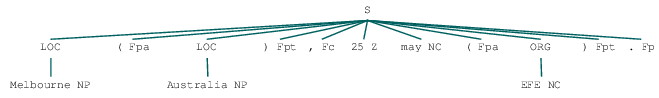

In [16]:
etr[0]

#### Q2.1 Features

1) Choosing good features for encoding the problem.

POS ,Word form ,ORT ,Prefix2 , Suffix2, prefix3 , suffix3.

In [7]:
import re
import string 
string.punctuation += '...'

def ORT(word):   
    if (re.match('\d+', word)):
        return 'number'
    elif (re.search('\d', word)):
        return 'contains-digit'
    elif (re.search('(?<=-)\w+', word)):
        return 'contains-hyphen'
    elif (word.istitle()):
        return 'capitalized'
    elif (re.match('[A-Z]+', word)):
        return 'all-capitalized'
    elif (re.match('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', word)):
        return 'url'
    elif (word in string.punctuation):
        return 'punctuation'
    else:
        return 'regular'
    

In [8]:
def get_feautres(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    features = {
        'bias': "",
        'Word-Form' : word.lower(),
        'Suffix3' : word[-3:],
        'Prefix3' : word[3:],
        'ORT' : ORT(word),
        'POS1' : postag,
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features['Previous Word-Form'] = word1.lower()
        features['Previous ORT'] = ORT(word1)
        features['Previous POS1'] = postag1
    else:
        features['BOS'] = ""
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features['Next Word-Form'] = word1.lower()
        features['Next ORT'] = ORT(word1)
        features['Next POS1'] = postag1
    else:
        features['EOS'] = ""
                
    return features


def sent_to_features(sent):
    return [get_feautres(sent, i) for i in range(len(sent))]


Let's test out our feature exctractor:

In [9]:
feature_train_sents = [sent_to_features(tree_sent.leaves()) for tree_sent in etr]

In [22]:
feature_train_sents[0]

[{'BOS': '',
  'Next ORT': 'punctuation',
  'Next POS1': 'Fpa',
  'Next Word-Form': '(',
  'ORT': 'capitalized',
  'POS1': 'NP',
  'Prefix3': 'bourne',
  'Suffix3': 'rne',
  'Word-Form': 'melbourne',
  'bias': ''},
 {'Next ORT': 'capitalized',
  'Next POS1': 'NP',
  'Next Word-Form': 'australia',
  'ORT': 'punctuation',
  'POS1': 'Fpa',
  'Prefix3': '',
  'Previous ORT': 'capitalized',
  'Previous POS1': 'NP',
  'Previous Word-Form': 'melbourne',
  'Suffix3': '(',
  'Word-Form': '(',
  'bias': ''},
 {'Next ORT': 'punctuation',
  'Next POS1': 'Fpt',
  'Next Word-Form': ')',
  'ORT': 'capitalized',
  'POS1': 'NP',
  'Prefix3': 'tralia',
  'Previous ORT': 'punctuation',
  'Previous POS1': 'Fpa',
  'Previous Word-Form': '(',
  'Suffix3': 'lia',
  'Word-Form': 'australia',
  'bias': ''},
 {'Next ORT': 'punctuation',
  'Next POS1': 'Fc',
  'Next Word-Form': ',',
  'ORT': 'punctuation',
  'POS1': 'Fpt',
  'Prefix3': '',
  'Previous ORT': 'capitalized',
  'Previous POS1': 'NP',
  'Previous Wor

These are the train sentences:

In [3]:
train_sents = [tree_sent.leaves() for tree_sent in etr]
test_sents = [tree_sent.leaves() for tree_sent in eta]

In [4]:
train_sents

[[('Melbourne', 'NP'),
  ('(', 'Fpa'),
  ('Australia', 'NP'),
  (')', 'Fpt'),
  (',', 'Fc'),
  ('25', 'Z'),
  ('may', 'NC'),
  ('(', 'Fpa'),
  ('EFE', 'NC'),
  (')', 'Fpt'),
  ('.', 'Fp')],
 [('-', 'Fg')],
 [('El', 'DA'),
  ('Abogado', 'NC'),
  ('General', 'AQ'),
  ('del', 'SP'),
  ('Estado', 'NC'),
  (',', 'Fc'),
  ('Daryl', 'VMI'),
  ('Williams', 'NC'),
  (',', 'Fc'),
  ('subrayó', 'VMI'),
  ('hoy', 'RG'),
  ('la', 'DA'),
  ('necesidad', 'NC'),
  ('de', 'SP'),
  ('tomar', 'VMN'),
  ('medidas', 'NC'),
  ('para', 'SP'),
  ('proteger', 'VMN'),
  ('al', 'SP'),
  ('sistema', 'NC'),
  ('judicial', 'AQ'),
  ('australiano', 'AQ'),
  ('frente', 'RG'),
  ('a', 'SP'),
  ('una', 'DI'),
  ('página', 'NC'),
  ('de', 'SP'),
  ('internet', 'NC'),
  ('que', 'PR'),
  ('imposibilita', 'VMI'),
  ('el', 'DA'),
  ('cumplimiento', 'NC'),
  ('de', 'SP'),
  ('los', 'DA'),
  ('principios', 'NC'),
  ('básicos', 'AQ'),
  ('de', 'SP'),
  ('la', 'DA'),
  ('Ley', 'NC'),
  ('.', 'Fp')],
 [('La', 'DA'),
  ('petición

2) Encode your training dataset.

In [5]:
import nltk
def word_to_label(sent, i):
    if type(sent[i]) is nltk.tree.Tree:
        lst = []
        s = ""
        for j in range(len(sent[i])):
            if j == 0:
                s = "B-"
            else:
                s = "I-"
            lst.append(s + sent[i].label())
        return lst
    else:
        return ["O"]

def sent_to_label(tree_sent):
    return [word_to_label(tree_sent, i) for i in range(len(tree_sent))]

Extract the features from the data:

In [10]:
feature_train_sents = [sent_to_features(tree_sent.leaves()) for tree_sent in etr]
label_train_sents = [sent_to_label(tree_sent) for tree_sent in etr]

feature_test_sents = [sent_to_features(tree_sent.leaves()) for tree_sent in eta]
label_test_sents = [sent_to_label(tree_sent) for tree_sent in eta]

We're going to test our label function on one sentence:

In [11]:
etr[0].leaves()

[('Melbourne', 'NP'),
 ('(', 'Fpa'),
 ('Australia', 'NP'),
 (')', 'Fpt'),
 (',', 'Fc'),
 ('25', 'Z'),
 ('may', 'NC'),
 ('(', 'Fpa'),
 ('EFE', 'NC'),
 (')', 'Fpt'),
 ('.', 'Fp')]

In [13]:
sent_to_label(etr[0])

[['B-LOC'],
 ['O'],
 ['B-LOC'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['O'],
 ['B-ORG'],
 ['O'],
 ['O']]

3) Run a classifier over the training dataset.

4) Train and test the model.

In [12]:
from sklearn.feature_extraction import DictVectorizer as dv
from sklearn.linear_model import LogisticRegression as lr
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('vectorizer', dv()), ('classifier', lr())])

In [13]:
flattened_f_test = [item for sublist in feature_test_sents for item in sublist]

In [14]:
flattened_f_train = [item for sublist in feature_train_sents for item in sublist]

In [15]:
flattened_l_test1 = [item for sublist in label_test_sents for item in sublist]

In [16]:
flattened_l_test2 = [item for sublist in flattened_l_test1 for item in sublist]

In [17]:
flattened_l_train1 = [item for sublist in label_train_sents for item in sublist]

In [18]:
flattened_l_train2 = [item for sublist in flattened_l_train1 for item in sublist]

In [51]:
up_flattened_f_train = [[feature_word] for feature_word in flattened_f_train]

In [52]:
len(up_flattened_f_train)

264715

In [44]:
len(flattened_l_train2)

264715

In [53]:
score = pipeline.fit(flattened_f_train, flattened_l_train2).score(flattened_f_test, flattened_l_test2)

In [54]:
score

0.95121213838973606

5) Perform error analysis and fine tune model parameters on the testa part of the datasets. 

We're going to tune the module by adding new features to see if there is an improvement:

In [19]:
def get_feautres2(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    features = {
        'bias': "",
        'Word-Form' : word.lower(),
        'Suffix3' : word[-3:],
        'Suffix2' : word[-2:],
        'Suffix1' : word[-1:],
        'Prefix3' : word[3:],
        'Prefix2' : word[2:],
        'Prefix1' : word[1:],
        'ORT' : ORT(word),
        'POS1' : postag,
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features['Previous Word-Form'] = word1.lower()
        features['Previous ORT'] = ORT(word1)
        features['Previous POS1'] = postag1
    else:
        features['BOS'] = ""
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features['Next Word-Form'] = word1.lower()
        features['Next ORT'] = ORT(word1)
        features['Next POS1'] = postag1
    else:
        features['EOS'] = ""
                
    return features


def sent_to_features2(sent):
    return [get_feautres2(sent, i) for i in range(len(sent))]


In [20]:
feature_train_sents2 = [sent_to_features2(tree_sent.leaves()) for tree_sent in etr]

feature_test_sents2 = [sent_to_features2(tree_sent.leaves()) for tree_sent in eta]

In [21]:
flattened_f_test2 = [item for sublist in feature_test_sents2 for item in sublist]
flattened_f_train2 = [item for sublist in feature_train_sents2 for item in sublist]

In [62]:
score2 = pipeline.fit(flattened_f_train2, flattened_l_train2).score(flattened_f_test2, flattened_l_test2)

In [63]:
score2

0.95234586096782115

Adding more features has improved our score by:

In [63]:
score2 - score

0.0011337225780850835

6) Perform evaluation over the testb part of the dataset, reporting on accuracy, per label precision, per label recall and per label F-measure, and confusion matrix. 

In [22]:
label_test_sents_b = [sent_to_label(tree_sent) for tree_sent in etb]

In [23]:
feature_test_sents_b = [sent_to_features2(tree_sent.leaves()) for tree_sent in etb]
flattened_f_test_b = [item for sublist in feature_test_sents_b for item in sublist]

In [24]:
flattened_l_test_b = [item for sublist in label_test_sents_b for item in sublist]
flattened_l_test_b = [item for sublist in flattened_l_test_b for item in sublist]

In [25]:
predected_labels = pipeline.fit(flattened_f_train2, flattened_l_train2).predict(flattened_f_test_b)
print(predected_labels)

['B-LOC' 'I-LOC' 'O' ..., 'O' 'O' 'O']


In [66]:
from sklearn import metrics
score3 = pipeline.fit(flattened_f_train2, flattened_l_train2).score(flattened_f_test_b, flattened_l_test_b)
print(score3)
print(metrics.classification_report(flattened_l_test_b, predected_labels))
print(metrics.confusion_matrix(flattened_l_test_b, predected_labels))

['B-LOC' 'I-LOC' 'O' ..., 'O' 'O' 'O']
0.961151107058
             precision    recall  f1-score   support

      B-LOC       0.74      0.74      0.74      1084
     B-MISC       0.53      0.44      0.48       340
      B-ORG       0.78      0.82      0.80      1400
      B-PER       0.79      0.88      0.83       735
      I-LOC       0.74      0.41      0.53       325
     I-MISC       0.62      0.30      0.41       556
      I-ORG       0.72      0.59      0.65      1104
      I-PER       0.84      0.91      0.87       634
          O       0.99      1.00      0.99     45355

avg / total       0.96      0.96      0.96     51533

[[  805     7   126    44    10     7    30     5    50]
 [   16   150    66    11     0    12    17     1    67]
 [   91    20  1154    80     2     3    19     1    30]
 [   27     4    14   647     1     3     7     5    27]
 [   31     7     9    12   133     7    50    33    43]
 [   19    30    19     7    10   168    86    17   200]
 [   80    52    5

Let's see these results in graph form:

In [39]:
import matplotlib.pyplot as plot
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [40]:
classification_report = precision_recall_fscore_support(flattened_l_test_b, predected_labels)

In [19]:
labels = ['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

In [42]:
%matplotlib inline
def label_plot(title, y_axis):
    plot.title(title)
    x_axis = range(9)
    plot.xticks(x_axis, labels)
    plot.plot(x_axis, y_axis)
    plot.show()

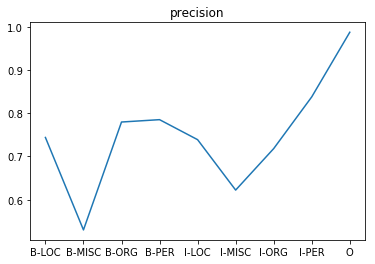

In [43]:
label_plot("precision", classification_report[0])

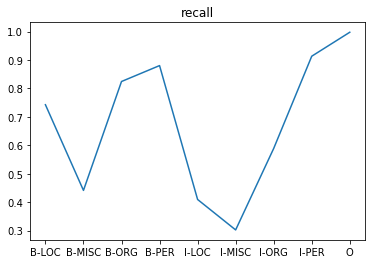

In [83]:
label_plot("recall", classification_report[1])

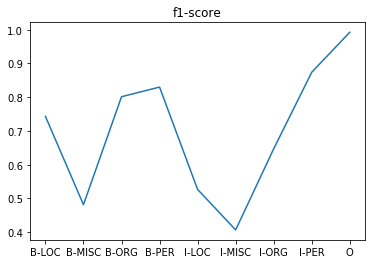

In [84]:
label_plot("f1-score", classification_report[2])

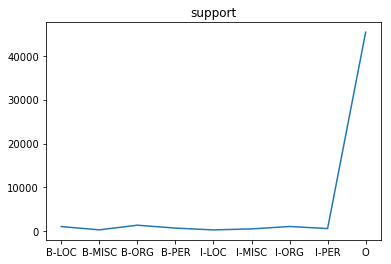

In [85]:
label_plot("support", classification_report[3])

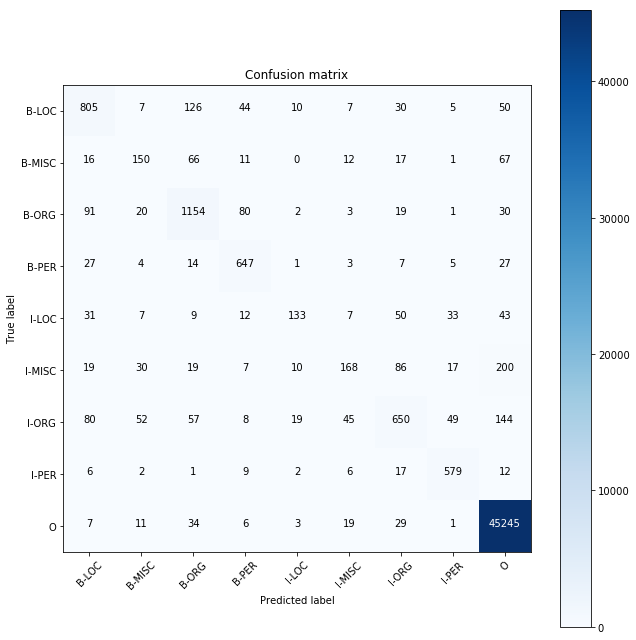

In [87]:
%matplotlib inline
import itertools
import numpy as np 
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plot.cm.Blues):
    plot.imshow(cm, interpolation='nearest', cmap=cmap)
    plot.title(title)
    plot.colorbar()
    tick_marks = np.arange(len(classes))
    plot.xticks(tick_marks, classes, rotation=45)
    plot.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plot.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plot.tight_layout()
    plot.ylabel('True label')
    plot.xlabel('Predicted label')

# Plot confusion matrix
plot.figure(figsize=(9,9))
plot_confusion_matrix(metrics.confusion_matrix(flattened_l_test_b, predected_labels), classes=labels, title='Confusion matrix')

### Q2.2 HMM and Viterbi

2.2.1 Implement the HMM algorithm discussed in class

In [183]:
flat_label_train_sents = []
for labels in label_train_sents:
    flat_labels = [item for sublist in labels for item in sublist]
    flat_label_train_sents.append(flat_labels)

In [184]:
flat_label_train_sents[0]

['B-LOC', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O']

In [185]:
train_untagged_sents = []
for tagged_sent in train_sents:
    sent = []
    for word,tag in tagged_sent:
        sent.append(word)
    train_untagged_sents.append(sent)

In [186]:
train_untagged_sents[0]

['Melbourne', '(', 'Australia', ')', ',', '25', 'may', '(', 'EFE', ')', '.']

In [187]:
flat_train_sents = [item for sublist in train_untagged_sents for item in sublist]

In [188]:
flat_label_train_sents[0]

['B-LOC', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O']

In [189]:
labels_sents = list(zip(train_untagged_sents, flat_label_train_sents))

In [190]:
labels_sents[0]

(['Melbourne', '(', 'Australia', ')', ',', '25', 'may', '(', 'EFE', ')', '.'],
 ['B-LOC', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O'])

In [191]:
labelled_sents = []
for sent,labels in labels_sents:
    labelled_sents.append(list(zip(labels,sent)))

In [192]:
labelled_sents[0]

[('B-LOC', 'Melbourne'),
 ('O', '('),
 ('B-LOC', 'Australia'),
 ('O', ')'),
 ('O', ','),
 ('O', '25'),
 ('O', 'may'),
 ('O', '('),
 ('B-ORG', 'EFE'),
 ('O', ')'),
 ('O', '.')]

our hmm algorithm requires special charecters to denote the begenning and end of each sentece, we chose asterisks

In [193]:
padded_labelled_sents = []
for sent in labelled_sents:
    # add * at the beginning
    padded_labelled_sents.append( ('*', '*') )
    # add labeled sentence
    for label_word in sent:
        padded_labelled_sents.append(label_word)
    # add ** at the end
    padded_labelled_sents.append( ('**', '**') )

In [194]:
padded_labelled_sents

[('*', '*'),
 ('B-LOC', 'Melbourne'),
 ('O', '('),
 ('B-LOC', 'Australia'),
 ('O', ')'),
 ('O', ','),
 ('O', '25'),
 ('O', 'may'),
 ('O', '('),
 ('B-ORG', 'EFE'),
 ('O', ')'),
 ('O', '.'),
 ('**', '**'),
 ('*', '*'),
 ('O', '-'),
 ('**', '**'),
 ('*', '*'),
 ('O', 'El'),
 ('B-PER', 'Abogado'),
 ('I-PER', 'General'),
 ('I-PER', 'del'),
 ('I-PER', 'Estado'),
 ('O', ','),
 ('B-PER', 'Daryl'),
 ('I-PER', 'Williams'),
 ('O', ','),
 ('O', 'subrayó'),
 ('O', 'hoy'),
 ('O', 'la'),
 ('O', 'necesidad'),
 ('O', 'de'),
 ('O', 'tomar'),
 ('O', 'medidas'),
 ('O', 'para'),
 ('O', 'proteger'),
 ('O', 'al'),
 ('O', 'sistema'),
 ('O', 'judicial'),
 ('O', 'australiano'),
 ('O', 'frente'),
 ('O', 'a'),
 ('O', 'una'),
 ('O', 'página'),
 ('O', 'de'),
 ('O', 'internet'),
 ('O', 'que'),
 ('O', 'imposibilita'),
 ('O', 'el'),
 ('O', 'cumplimiento'),
 ('O', 'de'),
 ('O', 'los'),
 ('O', 'principios'),
 ('O', 'básicos'),
 ('O', 'de'),
 ('O', 'la'),
 ('B-MISC', 'Ley'),
 ('O', '.'),
 ('**', '**'),
 ('*', '*'),
 ('O'

In [195]:
flat_labelled_sents = [item for sublist in labelled_sents for item in sublist]

In [196]:
flat_labelled_sents

[('B-LOC', 'Melbourne'),
 ('O', '('),
 ('B-LOC', 'Australia'),
 ('O', ')'),
 ('O', ','),
 ('O', '25'),
 ('O', 'may'),
 ('O', '('),
 ('B-ORG', 'EFE'),
 ('O', ')'),
 ('O', '.'),
 ('O', '-'),
 ('O', 'El'),
 ('B-PER', 'Abogado'),
 ('I-PER', 'General'),
 ('I-PER', 'del'),
 ('I-PER', 'Estado'),
 ('O', ','),
 ('B-PER', 'Daryl'),
 ('I-PER', 'Williams'),
 ('O', ','),
 ('O', 'subrayó'),
 ('O', 'hoy'),
 ('O', 'la'),
 ('O', 'necesidad'),
 ('O', 'de'),
 ('O', 'tomar'),
 ('O', 'medidas'),
 ('O', 'para'),
 ('O', 'proteger'),
 ('O', 'al'),
 ('O', 'sistema'),
 ('O', 'judicial'),
 ('O', 'australiano'),
 ('O', 'frente'),
 ('O', 'a'),
 ('O', 'una'),
 ('O', 'página'),
 ('O', 'de'),
 ('O', 'internet'),
 ('O', 'que'),
 ('O', 'imposibilita'),
 ('O', 'el'),
 ('O', 'cumplimiento'),
 ('O', 'de'),
 ('O', 'los'),
 ('O', 'principios'),
 ('O', 'básicos'),
 ('O', 'de'),
 ('O', 'la'),
 ('B-MISC', 'Ley'),
 ('O', '.'),
 ('O', 'La'),
 ('O', 'petición'),
 ('O', 'del'),
 ('B-PER', 'Abogado'),
 ('I-PER', 'General'),
 ('O', 

In [197]:
all_labels = [label for (label, word) in padded_labelled_sents]

In [198]:

len(all_labels)

281361

In [199]:
len(padded_labelled_sents)

281361

In [200]:
from nltk.probability import LidstoneProbDist

In [201]:
import nltk
# conditional frequency distribution
cfd_labelwords = nltk.ConditionalFreqDist(padded_labelled_sents)
cfd_labels = nltk.ConditionalFreqDist(nltk.bigrams(all_labels))

estimator = lambda fd: LidstoneProbDist(fd, 0.1)

# conditional probability distribution (parameter e)
cpd_labelwords = nltk.ConditionalProbDist(cfd_labelwords, estimator)

# make conditional probability distribution, using (parameter q)
cpd_labels = nltk.ConditionalProbDist(cfd_labels, nltk.MLEProbDist)

In [202]:
cfd_labelwords

ConditionalFreqDist(nltk.probability.FreqDist,
                    {'*': FreqDist({'*': 8323}),
                     '**': FreqDist({'**': 8323}),
                     'B-LOC': FreqDist({'Melbourne': 3,
                               'Australia': 10,
                               'Victoria': 3,
                               'Santander': 40,
                               'calle': 15,
                               'Cazoña': 1,
                               'Castilla': 2,
                               'Hermida': 1,
                               'Europa': 40,
                               'Cantabria': 24,
                               'Fráncfort': 17,
                               'RFA': 12,
                               'Suiza': 5,
                               'Mérida': 40,
                               'Extremadura': 25,
                               'Guipúzcoa': 13,
                               'Vera': 2,
                               'Cáceres': 40,
                   

In [203]:
distinct_labels = ['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

In [204]:
distinct_labels

['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']

In [205]:
def hmm(sentence):
    sentlen = len(sentence)
    viterbi = [ ]
    backpointer = [ ]
    first_viterbi = { }
    first_backpointer = { }
    
    for label in distinct_labels:
        if label == "*": continue
        first_viterbi[ label ] = cpd_labels["*"].prob(label) * cpd_labelwords[label].prob(sentence[0] )
        first_backpointer[ label ] = "*"
    
    viterbi.append(first_viterbi)
    backpointer.append(first_backpointer)

    currbest = max(first_viterbi.keys(), key = lambda label: first_viterbi[ label ])

    for wordindex in range(1, len(sentence)):
        this_viterbi = { }
        this_backpointer = { }
        prev_viterbi = viterbi[-1]
        
        for label in distinct_labels:
            if label == "*": continue
                
            best_previous = max(prev_viterbi.keys(), key = lambda prevlabel: prev_viterbi[ prevlabel ] * cpd_labels[prevlabel].prob(label) * cpd_labelwords[label].prob(sentence[wordindex]))
            this_viterbi[ label ] = prev_viterbi[ best_previous] * cpd_labels[ best_previous ].prob(label) * cpd_labelwords[label].prob(sentence[wordindex])
            this_backpointer[ label ] = best_previous

        currbest = max(this_viterbi.keys(), key = lambda tag: this_viterbi[label])

        viterbi.append(this_viterbi)
        backpointer.append(this_backpointer)

    prev_viterbi = viterbi[-1]
    best_previous = max(prev_viterbi.keys(), key = lambda prevlabel: prev_viterbi[ prevlabel ] * cpd_labels[prevlabel].prob("**"))

    prob_labelsequence = prev_viterbi[ best_previous ] * cpd_labels[ best_previous].prob("**")
    
    best_labelsequence = [ "**", best_previous ]
    backpointer.reverse()
    
    current_best_label = best_previous
    for bp in backpointer:
        best_labelsequence.append(bp[current_best_label])
        current_best_label = bp[current_best_label]

    best_labelsequence.reverse()
    return (best_labelsequence, prob_labelsequence)

Sanity check:

In [207]:
train_untagged_sents[0]

['Melbourne', '(', 'Australia', ')', ',', '25', 'may', '(', 'EFE', ')', '.']

In [208]:
print(hmm(train_untagged_sents[0]))

(['*', 'B-LOC', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', '**'], 7.7658532621008955e-31)


In [209]:
labelled_sents[0]

[('B-LOC', 'Melbourne'),
 ('O', '('),
 ('B-LOC', 'Australia'),
 ('O', ')'),
 ('O', ','),
 ('O', '25'),
 ('O', 'may'),
 ('O', '('),
 ('B-ORG', 'EFE'),
 ('O', ')'),
 ('O', '.')]

It seems to be working, now we can test it on the entire data set (testb).

These are the predicted labels from testb:

In [211]:
predected_labels

array(['B-LOC', 'I-LOC', 'O', ..., 'O', 'O', 'O'], 
      dtype='<U6')

We're going to run hmm over all the sentences from testb

In [212]:
test_sents_b = [tree_sent.leaves() for tree_sent in etb]

sents = []
for tagged_sent in test_sents_b:
    sent = []
    for word,tag in tagged_sent:
        sent.append(word)
    sents.append(sent)

In [213]:
sents[0]

['La', 'Coruña', ',', '23', 'may', '(', 'EFECOM', ')', '.']

In [214]:
hmm_sents = [hmm(sent) for sent in sents]

In [215]:
hmm_sents[0]

(['*', 'B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', '**'],
 9.212572828435062e-24)

Let's get all the labels that hmm predicted:

In [216]:
hmm_labels = [labels for labels,prob in hmm_sents]

We want to remove the paddings (the asterisks) becase those aren't part of the predicted labels

In [217]:
non_padded_hmm_labels = []
for labels in hmm_labels:
    for label in labels:
        if label != '*' and label != '**':
           non_padded_hmm_labels.append(label)

Let's check to make sure that we got the same amount of labels:

In [218]:
len(non_padded_hmm_labels)

51533

In [219]:
len(predected_labels)

51533

Now we want to see how many mistakes hmm made:

In [223]:
mistakes = 0
for i in range(len(non_padded_hmm_labels)):
    if non_padded_hmm_labels[i] != predected_labels[i]:
        mistakes += 1
mistakes

4064

In [224]:
(len(non_padded_hmm_labels)-mistakes)/len(non_padded_hmm_labels)

0.9211379116294414

We've got a very good percision score.